In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import csv

# importamos las librerías para el preprocesing y PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# importamos las librerías gráficas.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Importamos las librerias para Clustering.
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score

#Otros 
import warnings
warnings.filterwarnings('ignore')

# Dataset original

In [2]:
df_caba = pd.read_feather('./data/CovidCabaFeather')

### Parámetros del experimento

In [3]:
# 'preproc' es el parámetro que define el número de features que usaremos como input para el experimento.
# [6, 30, 'raw'] es la lista de parámetros que usaremos para desarrollar el presente trabajo.
#
# * 6 y 30, o cualquier número entero entre 1 y el número total de features en el dataset original (65), 
#   será la dimensión de nuestros samples para el proceso de clustering.
# * 'raw' es el único parámetro fuera de los antes mencionados que acepta el notebook y provoca que se usen los
#   features originales, evitando el proceso de PCA.

preproc = 6

# 'n_clusters' es el número de clusters que generará el notebook.
# [2, 4, 6] es el set de parámetros que usaremos para este trabajo.
#
# * Puede usarse cualquier número entero entre 1 y 6, eligiéndose este máximo para facilitar la visualización
#   de los resultados.

n_clusters = 6

### Limpieza del dataset

In [4]:
# Nos desacemos de las columnas que no formarán parte del estudio.

for columna in ['index', 
                'id_evento_caso', 
                'fecha_inicio_sintomas', 
                'fecha_apertura', 
                'fecha_internacion', 
                'fecha_cui_intensivo', 
                'fecha_fallecimiento',
                'carga_provincia_id',
                'fecha_diagnostico',
                'residencia_provincia_id',
                'residencia_departamento_id'
               ]: 
    df_caba.pop(columna)

In [5]:
# Generamos las que serán nuestras columnas dato.

df_caba.loc[df_caba.edad_años_meses == 'Meses', 'edad'] = df_caba.edad / 12
for columna in ['edad_años_meses']: df_caba.pop(columna) 

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['sexo'])], axis=1)
df_caba.rename(columns = {'M':'Masculino', 'F':'Femenino'}, inplace = True)
for columna in ['sexo', 'NR']: df_caba.pop(columna)
    
df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['residencia_pais_nombre'])], axis=1)
for columna in ['Bolivia', 'Paraguay', 'SIN ESPECIFICAR', 'Venezuela', 'residencia_pais_nombre']: df_caba.pop(columna) 
df_caba.rename(columns = {'Argentina':'residencia_Argentina'}, inplace = True)

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['carga_provincia_nombre'])], axis=1)
for columna in ['carga_provincia_nombre', 'residencia_provincia_nombre']: df_caba.pop(columna)
    
df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['residencia_departamento_nombre'])], axis=1)
for columna in ['residencia_departamento_nombre', 'SIN ESPECIFICAR']: df_caba.pop(columna)

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['origen_financiamiento'])], axis=1)
for columna in ['origen_financiamiento']: df_caba.pop(columna)

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['clasificacion_resumen'])], axis=1)
for columna in ['clasificacion_resumen']: df_caba.pop(columna) 

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['clasificacion'])], axis=1)
for columna in ['clasificacion']: df_caba.pop(columna) 

In [6]:
# Generamos las que serán nuestras columnas de control.

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['cuidado_intensivo'])], axis=1)
for columna in ['cuidado_intensivo', 'NO']: df_caba.pop(columna)
df_caba.rename(columns = {'SI':'cuidado_intensivo'}, inplace = True)

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['asistencia_respiratoria_mecanica'])], axis=1)
for columna in ['asistencia_respiratoria_mecanica', 'NO']: df_caba.pop(columna)
df_caba.rename(columns = {'SI':'asistencia_respiratoria_mecanica'}, inplace = True)

df_caba = pd.concat([df_caba, pd.get_dummies(df_caba['fallecido'])], axis=1)
for columna in ['fallecido', 'NO']: df_caba.pop(columna)
df_caba.rename(columns = {'SI':'fallecido'}, inplace = True)

In [7]:
# Drop NaNs

df_caba = df_caba.dropna(axis=0, how='any')

### dataset final

In [8]:
# Describimos los features que usaremos para nuestro estudio.
# * Shape del dataset
# * nombre de la columna
# * Type de la variable
# * Número de valores únicos
# * Número de Nulls
# * Muestra de los primeros 20 valores únicos

print(df_caba.shape)
for col in df_caba.keys():
    print('\n' + col + ' ' + str(type(df_caba[col][df_caba[col].first_valid_index()])) + '(' + str(len(df_caba[col].unique())) + ')[' + str(df_caba[col].isnull().sum()) + ' nulls]:')
    print(str(df_caba[col].unique()[0:20]))

(360877, 68)

edad <class 'numpy.float64'>(123)[0 nulls]:
[53. 69.  7. 46. 29. 61. 43. 38. 75. 55. 39. 48. 37. 50. 31. 47. 42. 35.
 54. 49.]

sepi_apertura <class 'numpy.int64'>(34)[0 nulls]:
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40  5  6]

Femenino <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Masculino <class 'numpy.uint8'>(2)[0 nulls]:
[1 0]

residencia_Argentina <class 'numpy.uint8'>(2)[0 nulls]:
[1 0]

Buenos Aires <class 'numpy.uint8'>(2)[0 nulls]:
[1 0]

CABA <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Catamarca <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Chaco <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Chubut <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Corrientes <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Córdoba <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Entre Ríos <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Formosa <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

Jujuy <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

La Pampa <class 'numpy.uint8'>(2)[0 nulls]:
[0 1]

La Rioja <class 'numpy.

# Preprocesing

In [9]:
# Definimos nuestros datos en función de los features que usaremos para agrupar nuestras muestras.

X = df_caba[list(df_caba.columns[:-3])]

In [10]:
# Definimos nuestros datos que usaremos como test para probar si existe relación con nuestros clusters.
# Reservaremos para esto: [cuidado_intensivo, asistencia_respiratoria_mecanica, fallecido]

Y = df_caba[list(df_caba.columns[-3:])]

In [11]:
# Escalamos nuestros datos.

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)

X_std = scaler.transform(X)
scaler

StandardScaler()

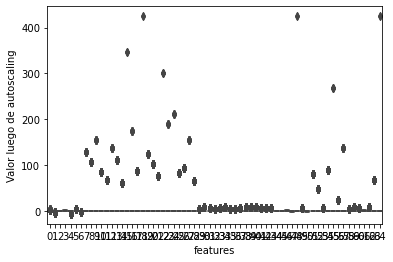

In [12]:
# visualizamos nuestros datos luego del autoscaling

sns.boxplot(data = pd.DataFrame(X_std))
plt.xlabel("features")
plt.ylabel("Valor luego de autoscaling")
plt.show()

# Principal Component Analysis

In [13]:
# Definimos el número de componentes principales en nuestro PCA en función del parámetro inicial 'preproc'.
n_comps = X_std.shape[1] if preproc == 'raw' else preproc

# Definimos nuestra decomposición PCA.
decomp_pca = PCA(n_components=n_comps, random_state=0)

# Transformamos nuestros datos escalados a nuestro nuevo espacio muestral.
pca_data = decomp_pca.fit_transform(X_std)

# Generamos nuestro nuevo DataFrame para trabajar.
xpca = pd.DataFrame(pca_data)

# Generamos nuesotrs eigenvalues, varianza y varianza acumulada para graficar más adelante.
eigenvalues = decomp_pca.explained_variance_ratio_
percentage_var_explained = decomp_pca.explained_variance_ / np.sum(decomp_pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

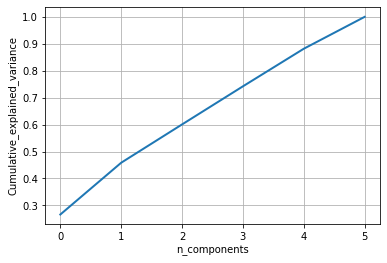

In [14]:
# Graficamos la participación acumulada de la varianza total de nuestros nuevos features.

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.savefig('clustering_' + str(preproc) + 'pre_cumulative.png', transparent=True)
plt.show()

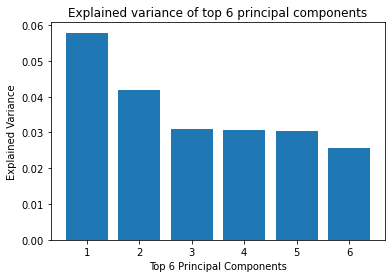

In [15]:
# Graficamos un Barplot con las features generadas por nuestro PCA.

components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top ' + str(n_comps) + ' principal components')
plt.xlabel('Top ' + str(n_comps) + ' Principal Components')
plt.ylabel('Explained Variance')
plt.savefig('clustering_' + str(preproc) + 'pre_bars.png', transparent=True)
plt.show()

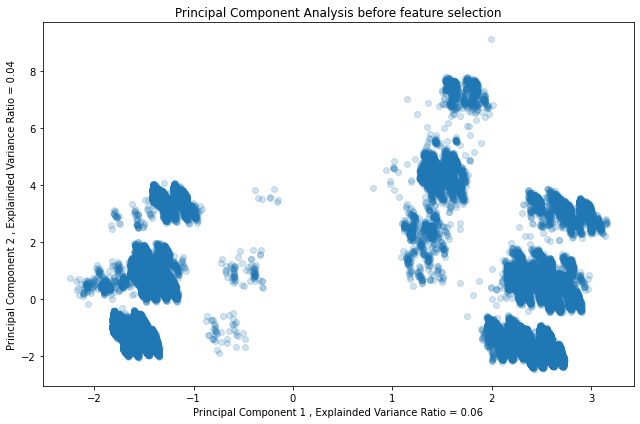

In [16]:
# Graficamos un Scatterplot de nuestros samples en las dos primeras dimensiones de nuestro PCA.

plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[:,0],xpca.loc[:,1], alpha = 0.2)    
plt.xlabel('Principal Component 1 , Explainded Variance Ratio = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance Ratio = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.tight_layout()
plt.savefig('clustering_2pca_scatter.png', transparent=True)
plt.show()

# Clustering

In [17]:
# Generamos un modelo de Kmeans de clusters con los datos autoscalados con StandardScaler.

datos = X_std if preproc == 'raw' else xpca # X_std #xpca
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(datos)

In [18]:
# Contamos cuantos samples asignamos en cada cluster.

for label, counts in zip(list(np.unique(kmeans.labels_, return_counts=True)[0]), list(np.unique(kmeans.labels_, return_counts=True)[1])):
    print('Cluster ' + str(label) + ': ' + str(counts))

Cluster 0: 116107
Cluster 1: 114657
Cluster 2: 10895
Cluster 3: 28376
Cluster 4: 90840
Cluster 5: 2


In [19]:
# Realizamos el mismo PCA que antes con solo dos dimensiones para identificar en un gráfico los nuevos clusters.

n_comps = 2
kmeans_pca = PCA(n_components=n_comps, random_state=0)
kmeans_xpca = pd.DataFrame(kmeans_pca.fit_transform(X_std))
kmeans_eigenvalues = kmeans_pca.explained_variance_ratio_

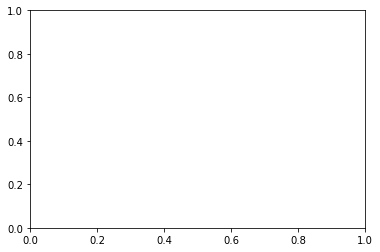

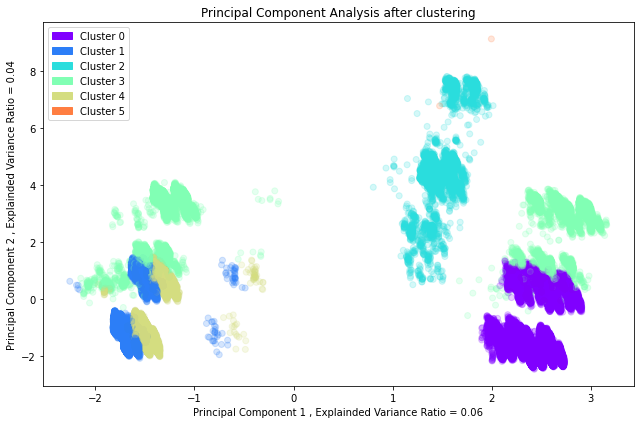

In [20]:
# Coloreamos nuestros samples en el espacio de las dos primeras dimensiones obtenidas del PCA.

y_pca = np.reshape(np.array(kmeans.labels_),(len(kmeans.labels_),1))
handlers = [('Cluster ' + str(i)) for i in range(n_clusters)]
col = np.zeros((len(y_pca[:,0]),4))
col_float = 1.0 / n_clusters
arrows = [plt.arrow(0,0, 0,0, head_width=0.0, color=np.reshape(cm.rainbow(np.linspace(i*col_float, i*col_float, 1)),(4,))) for i in range(n_clusters)]
for t in range(len(y_pca[:,0])):
    ray = y_pca[t,0] * col_float
    if y_pca[t,0]==0:
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))
    elif y_pca[t,0]==1: 
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))
    elif y_pca[t,0]==2:
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))
    elif y_pca[t,0]==3:
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))
    elif y_pca[t,0]==4:
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))
    elif y_pca[t,0]==5:
        col[t,] += np.reshape(cm.rainbow(np.linspace(ray, ray, 1)),(4,))

plt.figure(figsize=(9,6))
plt.scatter(kmeans_xpca.loc[:,0],kmeans_xpca.loc[:,1], c=col, alpha = 0.2)    
plt.xlabel('Principal Component 1 , Explainded Variance Ratio = ' + str(np.round(kmeans_eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance Ratio = ' + str(np.round(kmeans_eigenvalues[1],2)))
plt.title('Principal Component Analysis after clustering')
plt.legend(arrows, handlers, loc='upper left')
plt.tight_layout()
plt.savefig('Clustering_' + str(preproc) + 'pre-' + str(n_clusters) + 'clu.png', transparent=True)
plt.show()

# Evaluación

In [21]:
# Transformamos nuestra lista de labels a un dataset con una columna por cada label.

kmean_labels = pd.DataFrame(kmeans.labels_)
clusters_df = pd.get_dummies(kmean_labels[0])

In [22]:
# Para facilitar la evaluación de resultados el notebook genera un archivo .csv tipo log con las métricas de
# cada experimento.

metrics_file = 'cluster_metrics.csv'

In [23]:
# Calculamos el Silhouette Score de nuestro experimento.
# Siendo el dataset original de 360000+ samples, elegimos aleatoriamente una muestra representativa de 50000.

silhouette = silhouette_score(datos, kmean_labels, metric='euclidean', sample_size=50000, random_state=1000)
with open(metrics_file, 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow([preproc, n_clusters, 'silhouette', format(silhouette, '.4f')])
    count_row = [preproc, n_clusters, 'counts']

print('Silhouette score: ' + str(silhouette))

Silhouette score: 0.4747612599132052


In [24]:
# Imprimimos en nuestro archivo csv el recuento de samples en cada cluster.

count_row = [preproc, n_clusters, 'counts']
for count in list(np.unique(kmeans.labels_, return_counts=True)[1]):
    count_row = count_row + [str(count)]

with open(metrics_file, 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(count_row)

In [25]:
# A continuación se evalúa caso por caso la compatibilidad de nuestros clusters con nuestros datos de control.
# * cuidado_intensivo
# * asistencia_respiratoria_mecanica
# * fallecido
#
# Para esto usamos tres métricas propias de clustering y problemas de clasificación.
# * Accuracy: Equivalente al Rand Index de cada cluster. Expresa cuantas coincidencias existen entre los samples
#   en nuestro cluster y los samples positivos en nuestros datos de control.
# * Sensitivity: Mide el porcentaje de los casos positivos totales en nuestros datos de control que se encuentran
#   asignados a cada uno de nuestros clusters.
# * Overlap: Mide el porcentaje de la población de nuestro cluster que puede ser también clasificado como
#   positivo en nuestros datos de control. Es una métrica generada exclusivamente para este propósito. Su
#   nombre no responde a ninguna bibliografía.
#
# Se usan estas métricas como una adaptación para el fin que se busca en este estudio. Los casos positivos en
# nuestros datos de control son un porcentaje minúsculo y se busca tener en cuenta cada sample en la métrica del
# cluster al que pertenece exclusivamente.

In [26]:
# Métricas comparativas con los samples que clasificaron para Cuidado Intensivo.

ground_truth = 'cuidado_intensivo'
metrics_row = [preproc, n_clusters, ground_truth]
positives_row = [preproc, n_clusters, ground_truth]

for cluster in clusters_df.columns:
    y_true = Y[ground_truth]
    y_pred = clusters_df[cluster]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = (tn + tp) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    overlap = tp / (tp + fp)

    print('Cluster Nº' + str(cluster) + ':')
    print('\tAccuracy:\t' + str(accuracy) + '\t[' + str(tn+tp) + ']')
    print('\tSensitivity:\t' + str(sensitivity) + '\t[' + str(tp) + ']')
    print('\tOverlap:\t' + str(overlap) + '\t[' + str(tp) + ']')
    print('\n')
    
    metrics_row = metrics_row + [format(accuracy, '.4f'), format(sensitivity, '.4f'), format(overlap, '.4f')]
    positives_row = positives_row + [tp]
    
with open(metrics_file, 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(metrics_row)
    csvwriter.writerow(positives_row)

Cluster Nº0:
	Accuracy:	0.6766432884334551	[244185]
	Sensitivity:	0.43960355151765435	[2129]
	Overlap:	0.018336534403610463	[2129]


Cluster Nº1:
	Accuracy:	0.6744763451259016	[243403]
	Sensitivity:	0.20916787115424323	[1013]
	Overlap:	0.00883504714060197	[1013]


Cluster Nº2:
	Accuracy:	0.9574647317507073	[345527]
	Sensitivity:	0.04005781540367541	[194]
	Overlap:	0.017806333180357962	[194]


Cluster Nº3:
	Accuracy:	0.909816918229757	[328332]
	Sensitivity:	0.06958496799504439	[337]
	Overlap:	0.011876233436707077	[337]


Cluster Nº4:
	Accuracy:	0.7413440036355877	[267534]
	Sensitivity:	0.24158579392938262	[1170]
	Overlap:	0.012879788639365918	[1170]


Cluster Nº5:
	Accuracy:	0.9865743729858095	[356032]
	Sensitivity:	0.0	[0]
	Overlap:	0.0	[0]




In [27]:
# Métricas comparativas con los samples que clasificaron para Asistencia Respiratoria Mecánica.

ground_truth = 'asistencia_respiratoria_mecanica'
metrics_row = [preproc, n_clusters, ground_truth]
positives_row = [preproc, n_clusters, ground_truth]

for cluster in clusters_df.columns:
    y_true = Y[ground_truth]
    y_pred = clusters_df[cluster]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = (tn + tp) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    overlap = tp / (tp + fp)

    print('Cluster Nº' + str(cluster) + ':')
    print('\tAccuracy:\t' + str(accuracy) + '\t[' + str(tn+tp) + ']')
    print('\tSensitivity:\t' + str(sensitivity) + '\t[' + str(tp) + ']')
    print('\tOverlap:\t' + str(overlap) + '\t[' + str(tp) + ']')
    print('\n')
    
    metrics_row = metrics_row + [format(accuracy, '.4f'), format(sensitivity, '.4f'), format(overlap, '.4f')]
    positives_row = positives_row + [tp]
    
with open(metrics_file, 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(metrics_row)
    csvwriter.writerow(positives_row)

Cluster Nº0:
	Accuracy:	0.6788296289317413	[244974]
	Sensitivity:	0.5502463054187192	[1117]
	Overlap:	0.009620436321668806	[1117]


Cluster Nº1:
	Accuracy:	0.6784583112805749	[244840]
	Sensitivity:	0.16009852216748768	[325]
	Overlap:	0.0028345412840035935	[325]


Cluster Nº2:
	Accuracy:	0.9645724166405728	[348092]
	Sensitivity:	0.034482758620689655	[70]
	Overlap:	0.006424965580541533	[70]


Cluster Nº3:
	Accuracy:	0.9164202761605755	[330715]
	Sensitivity:	0.060098522167487685	[122]
	Overlap:	0.004299407950380603	[122]


Cluster Nº4:
	Accuracy:	0.744849353103689	[268799]
	Sensitivity:	0.19507389162561575	[396]
	Overlap:	0.004359313077939234	[396]


Cluster Nº5:
	Accuracy:	0.9943692726330579	[358845]
	Sensitivity:	0.0	[0]
	Overlap:	0.0	[0]




In [28]:
# Métricas comparativas con los samples que clasificaron como Fallecido o Fallecida.

ground_truth = 'fallecido'
metrics_row = [preproc, n_clusters, ground_truth]
positives_row = [preproc, n_clusters, ground_truth]

for cluster in clusters_df.columns:
    y_true = Y[ground_truth]
    y_pred = clusters_df[cluster]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = (tn + tp) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    overlap = tp / (tp + fp)

    print('Cluster Nº' + str(cluster) + ':')
    print('\tAccuracy:\t' + str(accuracy) + '\t[' + str(tn+tp) + ']')
    print('\tSensitivity:\t' + str(sensitivity) + '\t[' + str(tp) + ']')
    print('\tOverlap:\t' + str(overlap) + '\t[' + str(tp) + ']')
    print('\n')
    
    metrics_row = metrics_row + [format(accuracy, '.4f'), format(sensitivity, '.4f'), format(overlap, '.4f')]
    positives_row = positives_row + [tp]
    
with open(metrics_file, 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(metrics_row)
    csvwriter.writerow(positives_row)

Cluster Nº0:
	Accuracy:	0.6840862676202695	[246871]
	Sensitivity:	0.696171802054155	[3728]
	Overlap:	0.03210831388288389	[3728]


Cluster Nº1:
	Accuracy:	0.6700759538568543	[241815]
	Sensitivity:	0.08870214752567694	[475]
	Overlap:	0.004142791107389867	[475]


Cluster Nº2:
	Accuracy:	0.9560958442904369	[345033]
	Sensitivity:	0.03790849673202614	[203]
	Overlap:	0.018632400183570444	[203]


Cluster Nº3:
	Accuracy:	0.9092072922353045	[328112]
	Sensitivity:	0.09019607843137255	[483]
	Overlap:	0.017021426557654356	[483]


Cluster Nº4:
	Accuracy:	0.7360236313203667	[265614]
	Sensitivity:	0.08702147525676937	[466]
	Overlap:	0.0051298987230295025	[466]


Cluster Nº5:
	Accuracy:	0.985155607035084	[355520]
	Sensitivity:	0.0	[0]
	Overlap:	0.0	[0]


